In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


path = "e://python3/cv/"
file1="edges-lines-orig.png"#"2.jpg"#"chang.png""checker128-var20.png"
file2="bili_affine.jpg"
file3="mnn4-runway-Ohio.jpg"
img1h=256
img1w=256
img2h=255
img2w=255
img3h=425
img3w=478
L=256
img1 = Image.open(path+str(file1)) 
imageMatrix1 = np.matrix(img1.getdata())
img2 = Image.open(path+str(file2)) 
imageMatrix2 = np.matrix(img2.getdata())
img3 = Image.open(path+str(file3))
imageMatrix3 = np.matrix(img3.getdata())


In [2]:
#-------------------------------------image showing--------------------------------------------------------------
def grey_kernel(matrix):   #greying the 1D RGB image
    res=np.zeros(matrix.shape[0],dtype=np.uint8)
    for i in range(matrix.shape[0]):
        grey=np.uint8(round(0.299*matrix[i,0]+0.587*matrix[i,1]+0.114*matrix[i,2]))#matrix[i,0]#
        res[i]=grey
    return res

def squ_image(matrix,height,weight):
    res=np.array(matrix).reshape(height,weight)
    return res

def rgb_kernel(squ_array):   #RGBing the 2D grey image
    res=np.zeros([squ_array.shape[0],squ_array.shape[1],3],dtype=np.uint8)                        #NO NEED TOcalibration for display.
                                                                                  #squ_array-squ_array.min() :× squ_array can never be negative  
    for i in range(squ_array.shape[0]):
        for j in range(squ_array.shape[1]):
            res[i,j,0]=np.uint8(round(squ_array[i,j]))
            res[i,j,1]=np.uint8(round(squ_array[i,j]))
            res[i,j,2]=np.uint8(round(squ_array[i,j]))
    return res

def calibration(squ_array):   #RGBing the 2D grey image
    scale=squ_array.max()-squ_array.min()                          #calibration for display.
    if(scale==0):
        print("fail")
    else:
        squ_array=(squ_array-squ_array.min())/scale*255
    return squ_array

#---------------------------picture display------------------------
def showpic(raw,target1,target2,name1="filter 3 x 3",name2="filter 5 x 5"):       #show picture and save picture                                       
    fig=plt.figure(figsize=(15,5))    
    fig.add_subplot(131)
    plt.title("origin")
    plt.imshow(raw)
    fig.add_subplot(132)
    plt.title(name1)
    plt.imshow(target1,cmap=plt.cm.gray) 
    fig.add_subplot(133)
    plt.title(name2)
    plt.imshow(target2,cmap=plt.cm.gray) 
    
def showpic_g(raw,target1,name="gaussian filter 3 x 3"):       #show picture and save picture                                       
    fig=plt.figure(figsize=(15,5))    
    fig.add_subplot(121)
    plt.title("origin")
    plt.imshow(raw,cmap=plt.cm.gray)
    fig.add_subplot(122)
    plt.title(name)
    plt.imshow(target1,cmap=plt.cm.gray)   
    
def showpic_dxy(target1,target2,target3,target4):       #show picture and save picture                                       
    fig=plt.figure(figsize=(15,5))    
    fig.add_subplot(141)
    plt.title("dx")
    plt.imshow(target1,cmap=plt.cm.gray)
    fig.add_subplot(142)
    plt.title("dy")
    plt.imshow(target2,cmap=plt.cm.gray)
    fig.add_subplot(143)
    plt.title("edge map")
    plt.imshow(target3,cmap=plt.cm.gray)
    fig.add_subplot(144)
    plt.title("orientation map")
    plt.imshow(target4,cmap=plt.cm.gray)


#---------------------------conv2d------------------------------------------------------
def conv_2d(A,B,mode=1,padding="no"):
    if(padding=="zero"):
        
        C=np.zeros(B.shape)
        
        tempC=np.zeros([B.shape[0]+A.shape[0] - 1 , B.shape[1]+A.shape[1] - 1])
        xshift=int((A.shape[0] - 1 )/2)
        yshift=int((A.shape[1] - 1 )/2)
        tempC[xshift:-xshift,yshift:-yshift]=B
        B=tempC
        
    if(padding=="reflect"):
        tempC=np.zeros([B.shape[0]+A.shape[0] - 1 , B.shape[1]+A.shape[1] - 1])
        xshift=int((A.shape[0] - 1 )/2)
        yshift=int((A.shape[1] - 1 )/2)
        C=np.zeros(B.shape)
        
        tempC[xshift:-xshift,yshift:-yshift]=B
        tempC[xshift:-xshift,-yshift:]=B[:,:yshift]
        tempC[xshift:-xshift,:yshift]=B[:,-yshift:]
        tempC[:xshift,:]=tempC[-2*xshift:-xshift,:]
        tempC[-xshift:,:]=tempC[xshift:2*xshift,:]    
        
        B=tempC
    if(padding=="no"):
        C=np.zeros([B.shape[0]-A.shape[0] + 1 , B.shape[1]-A.shape[1] + 1],dtype=float)
    if(mode==1):
        for i in range(C.shape[0]):
            for j in range(C.shape[1]):
                C[i,j]=(A * B[i:i+A.shape[0],j:j+A.shape[1]]).sum()    #np.dot(A,Bxxx.T).trace()
    
    if(mode==2): 
        A=A-A.mean()                                                 #normalize the template ADD-square-SQRT,to match correlation<=1
        A=A/np.sqrt((A**2).sum())
        for i in range(C.shape[0]):
            for j in range(C.shape[1]):
                TEMP=B[i:i+A.shape[0],j:j+A.shape[1]]                #normalize the image window
                TEMP=TEMP-TEMP.mean()
                TEMP=TEMP/np.sqrt((TEMP**2).sum())
                C[i,j]=(A * TEMP).sum()

    return C


In [3]:
#----------------------------------------smooth kernel--------------------------------------------
sm_filter33=np.array(np.ones([3,3],dtype=float)) #python:    Matrix *Array *:stands for dot;  array*array:*stands for .*!!!!
sm_filter33/=9

sm_filter55=np.array(np.ones([5,5],dtype=float))
sm_filter55/=25

def smooth_filter(size):
    sm_filter=np.array(np.ones([size,size]),dtype=float)
    sm_filter/=(size**2)
    return sm_filter

#-------------------------------------gaussian kernel-------------------------------------------------------
sm_gauss=np.array([[1,2,1],[2,4,2],[1,2,1]],dtype=float)
sm_gauss/=16
def gaussian_filter(size):
    gau=np.zeros([size,size],dtype=float)
    thegma=np.sqrt(2.245/np.pi)
    for x in range(size):
        for y in range(size):
            gau[x,y]=1/(2*np.pi*thegma**2)*np.exp(-((x-int(size/2))**2+(y-int(size/2))**2)/(2*thegma**2))
    return gau/gau.sum()

#-----------------------------------second derivative-------------------------------------------------
dx=np.array([[-0.5,0,0.5]])
dy=np.array([[-0.5],[0],[0.5]])

#-----------------------------------laplacian kernel--------------------------------------------------
peak_lp=np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]],dtype=float)
peak_lp/=8

In [4]:
def rota_matrix(theta):
    theta=-theta/180*np.pi   #out theta transform from original to target
    return np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

def scale_matrix(x,y):
    x=1e-10 if x==0 else x
    y=1e-10 if y==0 else y                             #control division by 0
    return np.array([[1/x,0,0],[0,1/y,0],[0,0,1]])

def trans_matrix(x,y):                                  #attention: its negative:
    x=-x
    y=-y
    return np.array([[1,0,x],[0,1,y],[0,0,1]])

def shear_matrix(x,y):   # x-direction y shear ,     y-direction x shear
    x=-x
    y=-y
    return np.array([[1,x,0],[y,1,0],[0,0,1]])

def affine_matrix(a00,a01,a02,a10,a11,a12):
    return np.array([[a00,a01,a02],[a10,a11,a12],[0,0,1]])

def id_matrix():
    return np.array([[1,0,0],[0,1,0],[0,0,1]])

def NN_resampling(origin,target,operation):
     #initialize in function would be safe for python that outsider reuse of target would not change the type of target inside
    for x in range(target.shape[0]):
        for y in range(target.shape[1]):
            org_axis=np.dot(trans_matrix(int(target.shape[0]/2),int(target.shape[1]/2)),np.array([x,y,1]))
            org_axis=np.dot(operation,org_axis)     #python type dynamic binding
            org_axis=np.dot(trans_matrix(-int(target.shape[0]/2),-int(target.shape[1]/2)),org_axis)
            org_axis=np.round(org_axis)
            org_axis=org_axis.astype(int)
            if org_axis[0]>=0 and org_axis[1]>=0 and org_axis[0]<origin.shape[0] and org_axis[1]<origin.shape[1]:            
                                                                    #prevent index overflow and add pixel shift for rotation center
                target[x,y]=origin[org_axis[0],org_axis[1]]
                
def bili_resampling(origin,target,operation,mode=1):
    for x in range(target.shape[0]):
        for y in range(target.shape[1]):
            if(mode==1):
                org_axis=np.dot(trans_matrix(int(target.shape[0]/2),int(target.shape[1]/2)),np.array([x,y,1]))
                org_axis=np.dot(operation,org_axis)     #python type dynamic binding
                org_axis=np.dot(trans_matrix(-int(target.shape[0]/2),-int(target.shape[1]/2)),org_axis)
            if(mode==2):                #Rou,theta space image showing
                org_axis=np.dot(trans_matrix(int(target.shape[1]/2),0),[x,y,1])   #axis downside
            xlow=int(org_axis[0])       #bilinear use three edges, weight to the pixel bound
            xhigh=int(org_axis[0])+1
            ylow=int(org_axis[1])
            yhigh=int(org_axis[1])+1
            
            if org_axis[0]>=0 and org_axis[1]>=0 and xhigh<origin.shape[0] and yhigh<origin.shape[1]:            
                                                                    #prevent index overflow and add pixel shift for rotation center
                zx=origin[xlow,ylow]
                yx=origin[xhigh,ylow]
                zs=origin[xlow,yhigh]                           #what if origin<bound but ceil(origin)>bound,so change the boundary
                ys=origin[xhigh,yhigh]
                xx=org_axis[0]
                yy=org_axis[1]
                
                templowx=(xx-xlow)*zx + (xhigh-xx)*yx   
                temphighx=(xx-xlow)*zs + (xhigh-xx)*ys
                target[x,y]=(yy-ylow)*templowx + (yhigh-yy)*temphighx


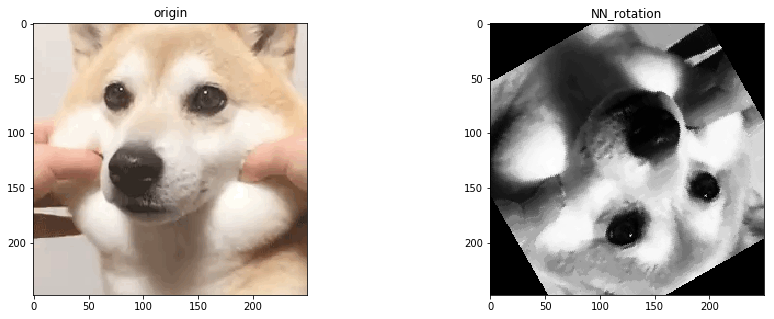

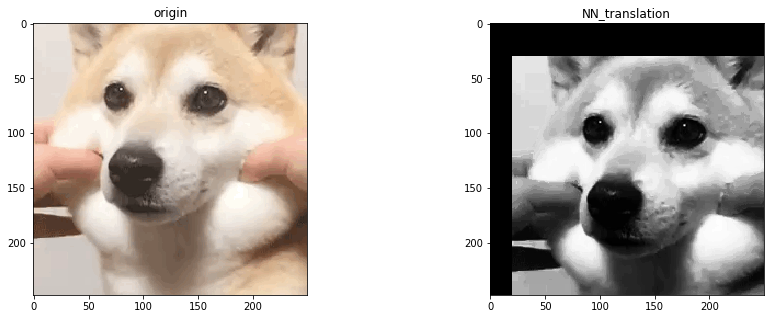

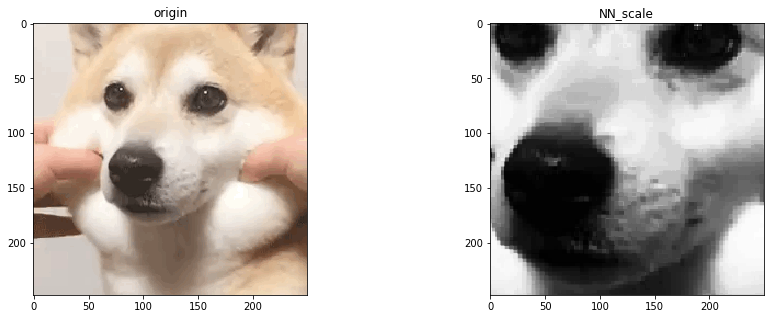

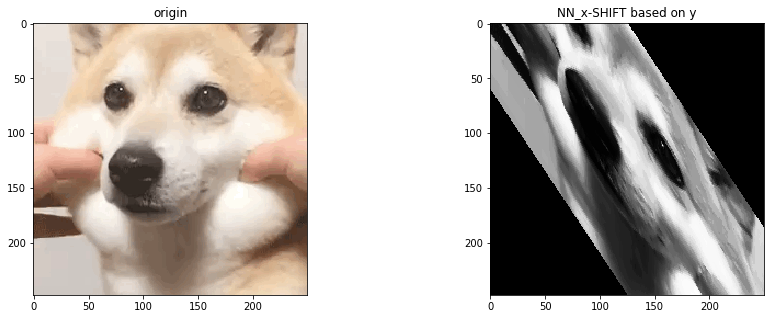

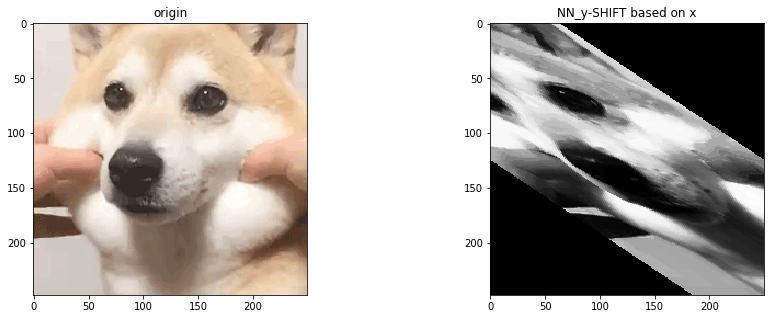

In [81]:
#----------------------------------------nn_resampling-------------------------------

#grey_lvl=grey_kernel(imageMatrix1)    #grey_lvl  [pixels,3]      #downside x, leftside y
squ=squ_image(imageMatrix1,img1h,img1w)

target0=np.zeros([img1h,img1w])   #create target map
NN_resampling(squ,target0,rota_matrix(210))   #resampling  rotation
target0=rgb_kernel(target0)
showpic_g(img1,target0,"NN_rotation")

target1=np.zeros([img1h,img1w]) 
NN_resampling(squ,target1,trans_matrix(30,20))   #resampling  translation
target1=rgb_kernel(target1)
showpic_g(img1,target1,"NN_translation")

target2=np.zeros([img1h,img1w]) 
NN_resampling(squ,target2,scale_matrix(2,2))   #resampling  scale
target2=rgb_kernel(target2)
showpic_g(img1,target2,"NN_scale")

target3=np.zeros([img1h,img1w]) 
NN_resampling(squ,target3,shear_matrix(1.5,0))   #resampling  scale
target3=rgb_kernel(target3)
showpic_g(img1,target3,"NN_x-SHIFT based on y")

target4=np.zeros([img1h,img1w]) 
NN_resampling(squ,target4,shear_matrix(0,1.5))   #resampling  scale
target4=rgb_kernel(target4)
showpic_g(img1,target4,"NN_y-SHIFT based on x")

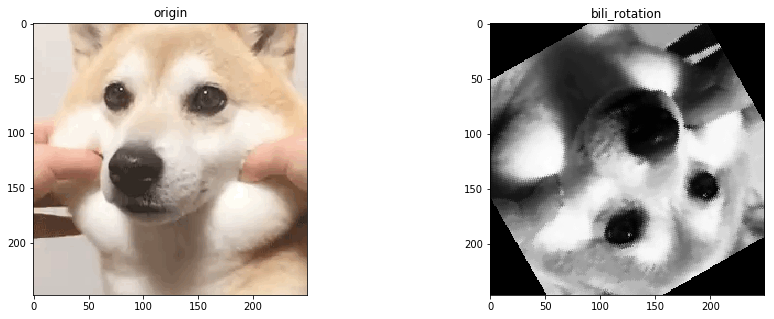

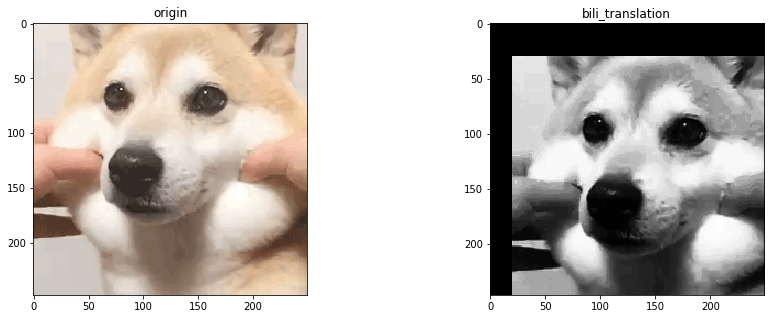

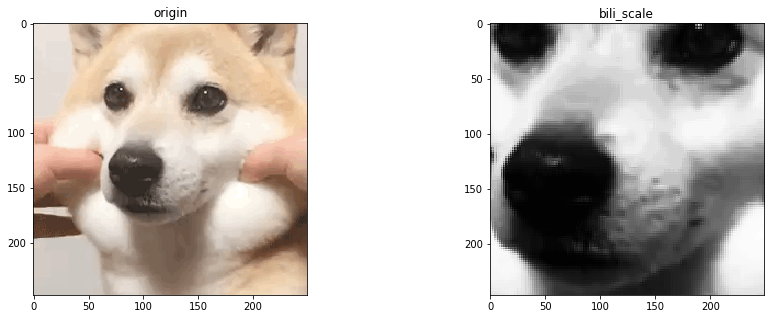

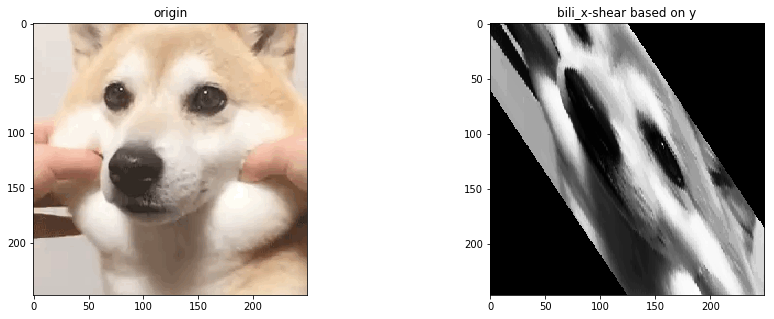

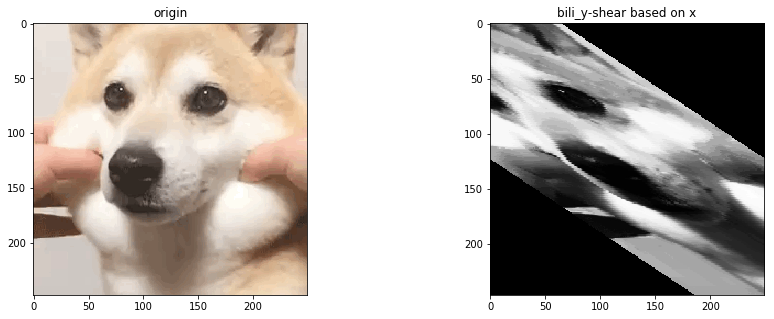

In [84]:
#------------------------------------------bili_resampling------------------------------------
#grey_lvl=grey_kernel(imageMatrix1)    #grey_lvl  [pixels,3]      #downside x, leftside y
squ=squ_image(imageMatrix1,img1h,img1w)

target10=np.zeros([img1h-1,img1w-1])   #create target map                        bilinear lose one pixel resolution
bili_resampling(squ,target10,rota_matrix(210))   #resampling  rotation          
target10=rgb_kernel(target10)
showpic_g(img1,target10,"bili_rotation")

target11=np.zeros([img1h-1,img1w-1]) 
bili_resampling(squ,target11,trans_matrix(30,20))   #resampling  translation
target11=rgb_kernel(target11)
showpic_g(img1,target11,"bili_translation")

target12=np.zeros([img1h-1,img1w-1]) 
bili_resampling(squ,target12,scale_matrix(2,2))   #resampling  scale
target12=rgb_kernel(target12)
showpic_g(img1,target12,"bili_scale")

target13=np.zeros([img1h-1,img1w-1]) 
bili_resampling(squ,target13,shear_matrix(1.5,0))   #resampling  shear
target13=rgb_kernel(target13)
showpic_g(img1,target13,"bili_x-shear based on y")

target14=np.zeros([img1h-1,img1w-1]) 
bili_resampling(squ,target14,shear_matrix(0,1.5))   #resampling  shear
target14=rgb_kernel(target14)
showpic_g(img1,target14,"bili_y-shear based on x")

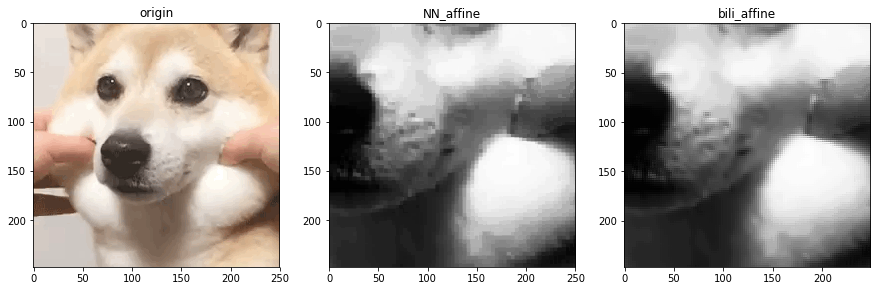

In [87]:
#---------------------------------for general affine effects----------------------------------------------
#grey_lvl=grey_kernel(imageMatrix1)    #grey_lvl  [pixels,3]      #downside x, leftside y
squ=squ_image(imageMatrix1,img1h,img1w)

targetnn=np.zeros([img1h,img1w])   #create target map
NN_resampling(squ,targetnn,affine_matrix(0.5,0,25,0,0.5,33))   #resampling  rotation
targetnn=rgb_kernel(targetnn)

targetbl=np.zeros([img1h-1,img1w-1])   #create target map                        bilinear lose one pixel resolution
bili_resampling(squ,targetbl,affine_matrix(0.5,0,25,0,0.5,33))   #resampling  rotation          
targetbl=rgb_kernel(targetbl)
showpic(img1,targetnn,targetbl,name1="NN_affine",name2="bili_affine")

plt.imsave('NN_affine.jpg',targetnn)
plt.imsave('bili_affine.jpg',targetbl)

In [7]:
#-----------------------------for collecting points----------------------------------
def interactive_collect_points(img11,img22,img1h,img1w,img2h,img2w):
    def drag_key(event, x, y, flags, param):
        #print type(param[0]), param[1]
        if event == cv2.EVENT_LBUTTONDBLCLK:
            if param[2] == 1:
                param[1][0].append([y-int(img1w/2),x-int(img1h/2)])  #they let down=y, right=x,only deceptive transform hidden inside
            if param[2] == 2:
                param[1][1].append([y-int(img2w/2),x-int(img2h/2)])   #transform from left hand to right hand !!!!
            cv2.circle(param[0], (x,y), 3, (255,0,0), -1)

    a = [[],[]]                                          #first dimension stores target,second stores source
    cv2.namedWindow('image1')
    cv2.namedWindow('image2')

    cv2.setMouseCallback('image1', drag_key, [img11, a, 1]) #1 stands for source landmark
    cv2.setMouseCallback('image2', drag_key, [img22, a, 2]) #2 stands for target landmark

    while(1):
        cv2.imshow('image1',img11)
        cv2.imshow('image2',img22)
        if cv2.waitKey(20) & 0xFF == 27:
            break
    cv2.destroyAllWindows()
    return np.array(a)

#-------------------------------for saving points-----------------------
def stack_points(a):   
    X=[]      #couldnot use np.array([]) becasue, donot have X.append,CAN only list.append
    Y=[]
    for i in range(a.shape[1]):
        temp1=np.append(a[1][i],[1,0,0,0]).tolist()
        temp2=np.concatenate(([0,0,0],a[1][i],[1])).tolist()
        X.append(temp1)    #concatenate
        X.append(temp2)
        Y.append(a[0][i][0])
        Y.append(a[0][i][1])
    return X,Y

#--------------------------------for solving equations-----------------------------
def linear_equation(X,Y):
    aff=np.linalg.lstsq(X,Y)[0]
    match_matrix=np.array([[aff[0],aff[1],aff[2]],[aff[3],aff[4],aff[5]],[0,0,1]])
    return match_matrix

#------------------------------------for showing landmarks on effect picture------------------
def coloring_picture(file,landmarks,match_matrix):
    img33=cv2.imread(file)
    for i in range(landmarks.shape[1]):
        temp=np.dot(np.linalg.inv(match_matrix),np.append(landmarks[0][i],[1]))   #0 stands for source
        temp=np.dot(trans_matrix(int(-img33.shape[0]/2),int(-img33.shape[1]/2)),temp).astype(np.int)
        cv2.circle(img33, (temp[1],temp[0]), 3, (255,0,0), -1)
    return img33

e:\learning software\python\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


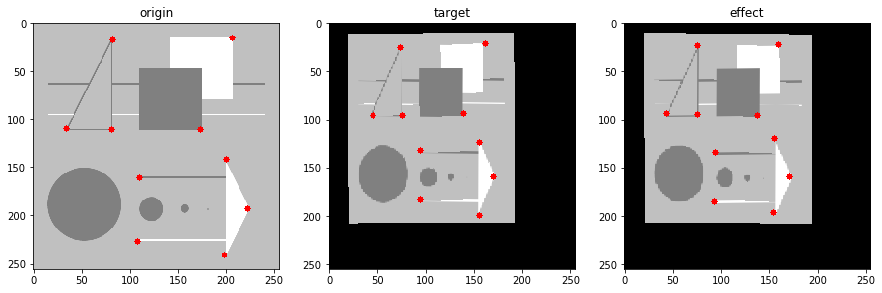

In [11]:
#-------------------------------------for transformation matching----------------------------
img11 = cv2.imread(path+str(file1))
img22 = cv2.imread(path+str(file2))
landmarks=interactive_collect_points(img11,img22,img1h,img1w,img2h,img2w)
X,Y=stack_points(landmarks)
Transformation=linear_equation(X,Y)
#----------------------------for showing the result image and landmarks---------------------------------
grey_lvl=grey_kernel(imageMatrix1)    #grey_lvl  [pixels,3]      #downside x, leftside y
squ=squ_image(grey_lvl,img1h,img1w)

target30=np.zeros([img1h-1,img1w-1])   #create target map                        bilinear lose one pixel resolution
bili_resampling(squ,target30,Transformation)   #resampling  rotation          
target30=rgb_kernel(target30)
plt.imsave('matching_effect.jpg',target30)

file_m='matching_effect.jpg'
img33=coloring_picture(file_m,landmarks,Transformation)
showpic(img11,img22,img33,name1="target",name2="effect")

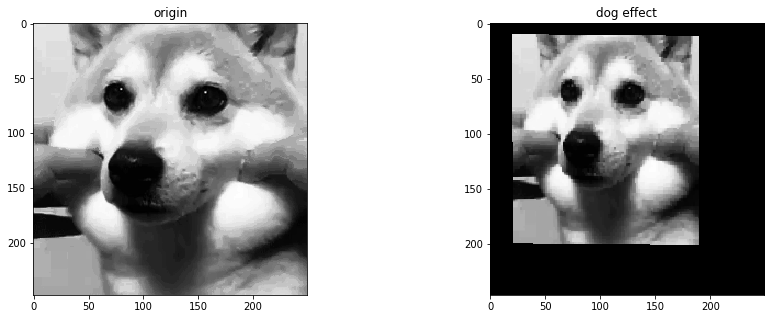

In [13]:
'''squ_sam=squ_image(imageMatrix1,img1h,img1w)

target30=np.zeros([img1h-1,img1w-1])   #create target map                        bilinear lose one pixel resolution
bili_resampling(squ_sam,target30,Transformation)   #resampling  rotation          
target30=rgb_kernel(target30)

showpic_g(rgb_kernel(squ_sam),target30,name="dog effect")'''

In [822]:
#part 2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
path = "e://python3/cv/"
file1="edges-lines-orig.png"#"2.jpg"#"chang.png""checker128-var20.png"
file2="bili_affine.jpg"
file3="mnn4-runway-Ohio.jpg"
img1h=256
img1w=256
img2h=255
img2w=255
img3h=425
img3w=478
L=256
img1 = Image.open(path+str(file1)) 
imageMatrix1 = np.matrix(img1.getdata())
img2 = Image.open(path+str(file2)) 
imageMatrix2 = np.matrix(img2.getdata())
img3 = Image.open(path+str(file3))
imageMatrix3 = np.matrix(img3.getdata())

#imageMatrix1 = np.matrix(imageMatrix1,dtype=float)


In [32]:
def coordinate_generator(size):
    h=np.arange(size[0])
    h=h[:,np.newaxis]
    hoz=np.array([[]for i in range(size[0])])
    for i in range(size[1]):
        hoz=np.hstack((hoz,h)).astype(np.int)
    v=np.arange(size[1])
    v=v[:,np.newaxis]
    ver=np.array([[]for i in range(size[1])])
    for i in range(size[0]):
        ver=np.hstack((ver,v)).astype(np.int)
    ver=ver.transpose()
    #print(hoz,ver)
    return hoz,ver
def axis_shift_operation(operation,In,Out,x,y,mode="single_point"):
    if mode=="single_point":
        org_axis1=np.dot(trans_matrix(int(In.shape[0]/2),int(In.shape[1]/2)),np.array([x,y,1])) #[3 x 1]
        org_axis2=operation(org_axis1)     # [3 x 1]
        org_axis=np.dot(trans_matrix(-int(Out.shape[0]/2),-int(Out.shape[1]/2)),org_axis2)
        return org_axis
    if mode=="array":
        org_axis1=Axis_shift_2D(x,y,In,mode=1)
        org_axis2=operation(org_axis1)
        org_axis=Axis_shift_2D(org_axis2[0],org_axis2[1],Out,mode=2)
        return org_axis

def edge_laplacian(squ,threthod=0):          #reduce 2+2  (gauss+2,derivative+2)
    C = conv_2d(sm_gauss,squ)
    rgb_lvlC=rgb_kernel(C)
    showpic_g(rgb_kernel(squ),rgb_lvlC)

    edgeX=conv_2d(dx,C)
    edgeY=conv_2d(dy,C)
    edgeXY=np.sqrt(edgeX[:-2,:]**2+edgeY[:,:-2]**2)
    angleXY=np.arctan2(edgeY[:,:-2],edgeX[:-2,:])

    edgeX=calibration(edgeX)
    edgeY=calibration(edgeY)
    edgeXY=calibration(edgeXY)
    angleXY=calibration(angleXY)
    
    edgeXY[edgeXY<threthod]=0          #threthoding=70 
    
    rgb_lvlX=rgb_kernel(edgeX)  
    rgb_lvlY=rgb_kernel(edgeY)
    rgb_lvlXY=rgb_kernel(edgeXY)            #40 for image display
    showpic_dxy(rgb_lvlX,rgb_lvlY,rgb_lvlXY,angleXY)
   
    return edgeXY,angleXY

def peak_detection(X,resolution):
    Y=np.zeros(X.shape)
    X_enlarge=np.zeros(np.array(X.shape)+resolution-1)
    
    xshift=int(resolution/2)
    yshift=int(resolution/2)
    X_enlarge[xshift:-xshift,yshift:-yshift]=X
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i,j]=X[i,j] if X[i,j]==np.max(X_enlarge[i:i+resolution,j:j+resolution]) else 0
    return Y           

def draw_lines(x,y,in_img):      #in_img[x][y]
    Xupsample_scale=1
    Yupsample_scale=1
    Xraw=np.arange(in_img.shape[0]*Xupsample_scale)/Xupsample_scale
    Yraw=np.arange(in_img.shape[1]*Yupsample_scale)/Yupsample_scale
    new_img=np.copy(in_img)
    for i in range(x.shape[0]):#
        if x[i] < 45. or x[i] > 135. :
            X=-np.tan(x[i]/180*np.pi)*Yraw+y[i]/np.cos(x[i]/180*np.pi)
            a=np.array(np.where(X>=0))
            b=np.array(np.where(X<in_img.shape[0]))
            g=np.intersect1d(a,b)
            #plt.plot(X.astype(int)[g],Yraw.astype(int)[g])
            mark_correspond_key(X.astype(int)[g],Yraw.astype(int)[g],new_img)
        elif x[i] >= 45. and x[i] <= 135. :
            Y=-1/np.tan(x[i]/180*np.pi)*Xraw+y[i]/np.sin(x[i]/180*np.pi)
            a=np.array(np.where(Y>=0))
            b=np.array(np.where(Y<in_img.shape[1]))
            g=np.intersect1d(a,b)

            #plt.plot(Xraw.astype(int)[g],Y.astype(int)[g])
            mark_correspond_key(Xraw.astype(int)[g],Y.astype(int)[g],new_img)
    #print(new_img.shape)
    rgb_lvl=rgb_kernel(new_img)
    showpic_g(rgb_kernel(in_img),rgb_lvl,name="original img")

def Axis_shift_2D(x,y,img,mode=1):    #x and y are arrays  img[x][y]
        def concat_(a):    #[# x 2] 
            X=[]      #couldnot use np.array([]) becasue, donot have X.append,CAN only list.append
            for i in range(a.shape[0]):
                temp1=np.append(a[i],[1,0,0,0]).tolist()
                temp2=np.concatenate(([0,0,0],a[i],[1])).tolist()
                X.append(temp1)    #concatenate
                X.append(temp2)
            return X
        temp=np.vstack((x,y)).transpose()
        X=concat_(temp)
        if(mode==1):
            A=np.hstack((trans_matrix(-int(img.shape[0]/2),0)[0],trans_matrix(-int(img.shape[0]/2),0)[1]))
        if(mode==2):
            A=np.hstack((trans_matrix(int(img.shape[0]/2),0)[0],trans_matrix(int(img.shape[0]/2),0)[1]))
        Y=np.dot(X,A)
        Y=Y.reshape(x.shape[0],2).transpose()
        return Y[0],Y[1]

def vote_cell_round(x,resolution):    
    y=(x/resolution).astype(np.int)
    return y

def x_upsampling(x,scale):
    newx=np.arange((x.max()+1)*scale)
    return newx

def y_downsampling(y,scale):
    newy=y/scale
    return newy
    
def mark_correspond_key(y,x,img):
    img[y,x]=255   
    
 
    



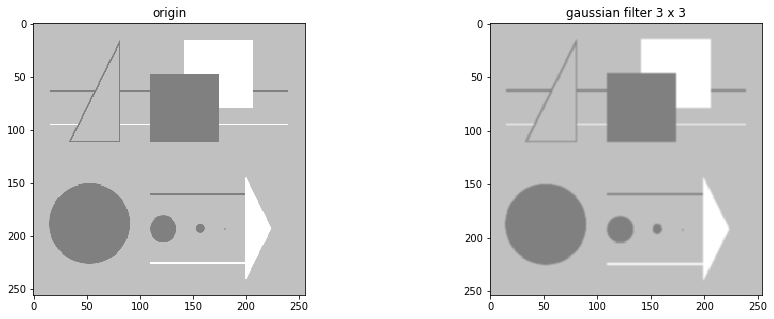

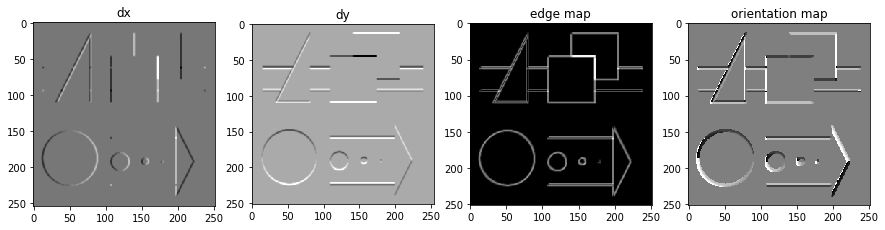

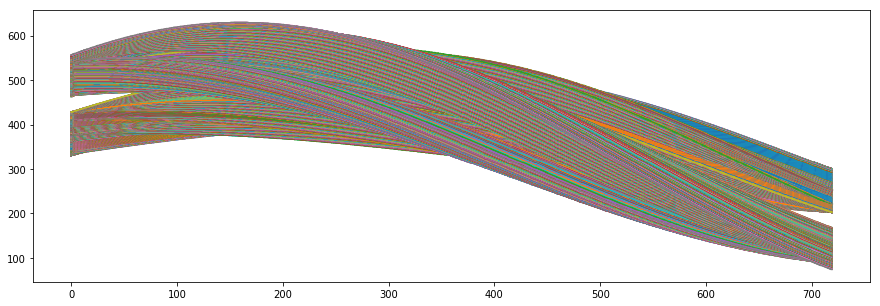

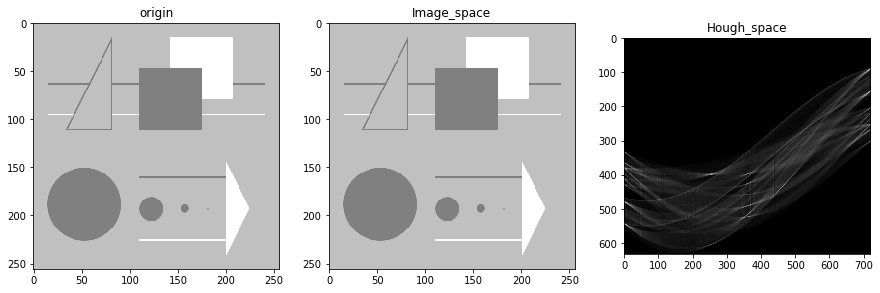

In [846]:
#---------------------------performing the Hough transformation
threthod=75
cell_size=1                        #set the cell size
                                    #stretch the theta axis to make a continus curve
x_sample_scale=2             #stretch the theta axis to make a good figure display
y_compress_scale=1

theta_resolution=720
#x_general_scale=theta_resolution/cell_size=360/2=180
#y_general_scale=max/y_compress_scale/cell_size=1200/6=200

grey_lvl=grey_kernel(imageMatrix1)    #grey_lvl  [pixels,3]      #downside x, leftside y
squ=squ_image(grey_lvl,img1h,img1w)
#squ=squ_image(imageMatrix3,img3h,img3w) a

edgeXY,angleXY=edge_laplacian(squ)
Vote_img=Img2Hough(edgeXY,angleXY,threthod,theta_resolution,y_compress_scale,cell_size,poll_mode="non_weighted",speed_up="no")
Vote_img1=calibration(Vote_img)
Vote_img1=rgb_kernel(Vote_img1)

showpic(rgb_kernel(squ),rgb_kernel(squ),Vote_img1,name1="Image_space",name2="Hough_space")


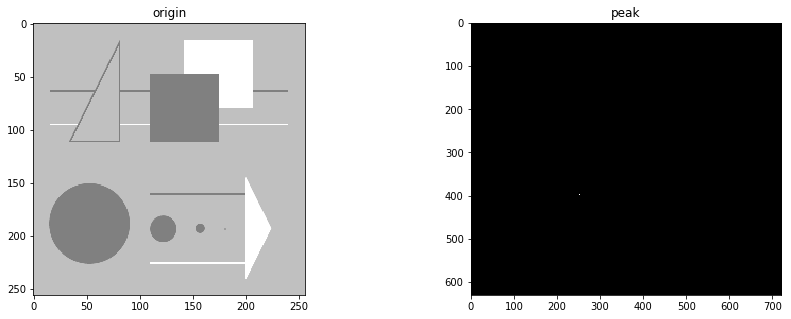

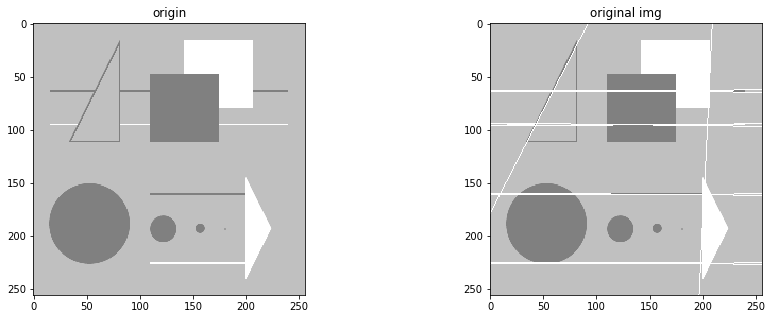

In [854]:
threthod=0.6
resolution=21
resolution=int(resolution/2)*2+1   #make the resolution an odd number

Vote_img2=calibration(Vote_img)   #after image display,we need to calibration to return to normal

Vote_smooth=np.zeros(Vote_img2.shape)
Vote_smooth=conv_2d(gaussian_filter(resolution),Vote_img2,padding="reflect")

peak=peak_detection(Vote_smooth,resolution)   #use non-linear peak detection
newPK=np.zeros(peak.shape)#np.zeros(peak.shape)
newPK[peak>(threthod*peak.max())]=255


rgb_lvl=rgb_kernel(newPK)
showpic_g(rgb_kernel(squ),rgb_lvl,name="peak")

temp_key=np.array(np.where(newPK==255),dtype=np.float)

final_key=Axis_shift_2D(temp_key[0],temp_key[1],newPK,mode=2)
final_key=np.array(final_key)

final_key[0]=(final_key[0]*cell_size+int(cell_size/2))*y_compress_scale          #rou / x in matrix
final_key[1]=(final_key[1]*cell_size+int(cell_size/2))/theta_resolution*180      #theta /y in matrix
draw_lines(final_key[1],final_key[0],squ)


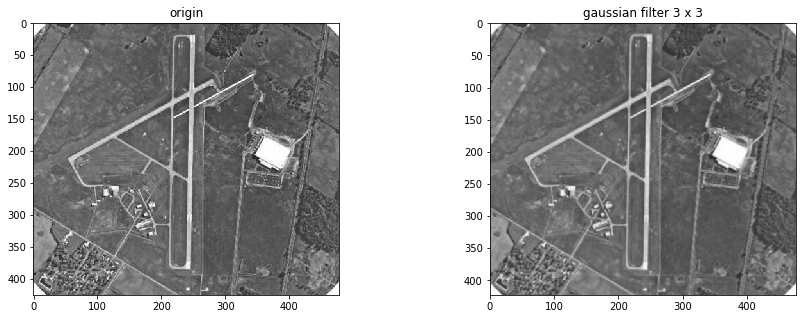

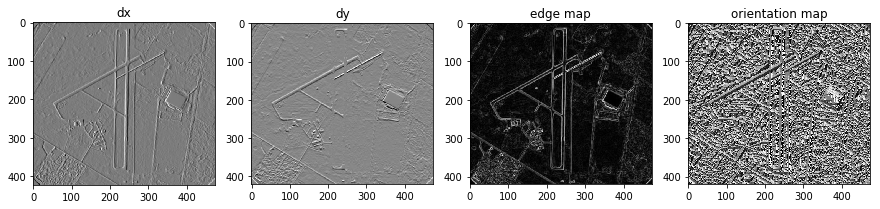

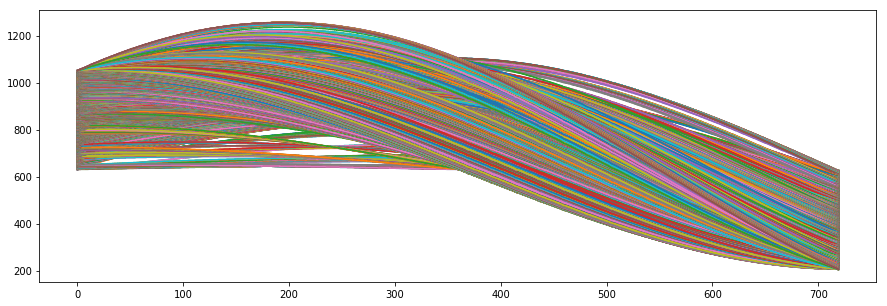

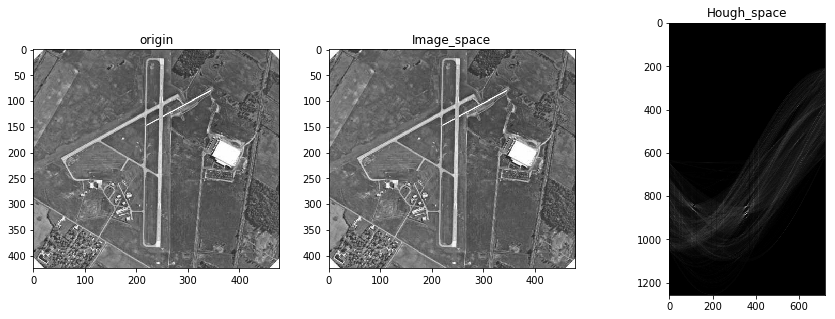

In [10]:
#---------------------------performing the Hough transformation
threthod=75
cell_size=1                        #set the cell size
                                    #stretch the theta axis to make a continus curve
x_sample_scale=2             #stretch the theta axis to make a good figure display
y_compress_scale=1

theta_resolution=720
#x_general_scale=theta_resolution/cell_size=360/2=180
#y_general_scale=max/y_compress_scale/cell_size=1200/6=200

squ1=squ_image(imageMatrix3,img3h,img3w)
edgeXY1,angleXY1=edge_laplacian(squ1)
Vote_img_ap=Img2Hough(edgeXY1,angleXY1,threthod,theta_resolution,y_compress_scale,cell_size,poll_mode="non_weighted",speed_up="no")
Vote_img1=calibration(Vote_img_ap)
Vote_img1=rgb_kernel(Vote_img1)

showpic(rgb_kernel(squ1),rgb_kernel(squ1),Vote_img1,name1="Image_space",name2="Hough_space")


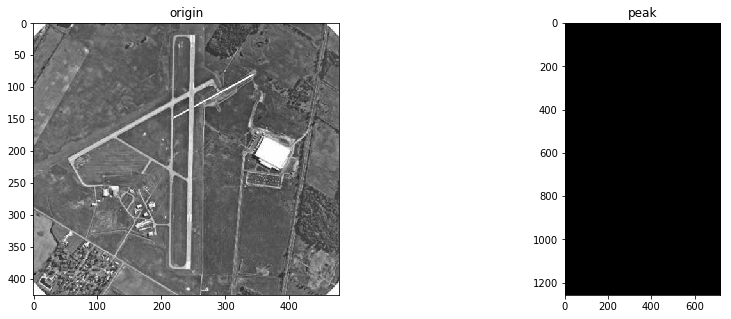

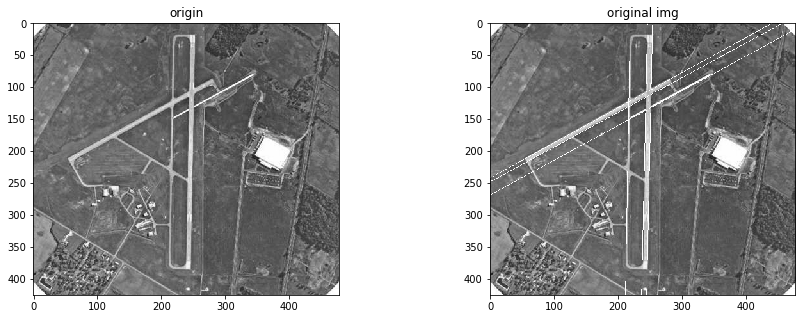

In [25]:
threthod=0.5
resolution=11
resolution=int(resolution/2)*2+1   #make the resolution an odd number

Vote_img2=calibration(Vote_img_ap)   #after image display,we need to calibration to return to normal

Vote_smooth=np.zeros(Vote_img2.shape)
Vote_smooth=conv_2d(gaussian_filter(resolution),Vote_img2,padding="reflect")

peak=peak_detection(Vote_smooth,resolution)   #use non-linear peak detection
newPK=np.zeros(peak.shape)#np.zeros(peak.shape)
newPK[peak>(threthod*peak.max())]=255


rgb_lvl=rgb_kernel(newPK)
showpic_g(rgb_kernel(squ1),rgb_lvl,name="peak")

temp_key=np.array(np.where(newPK==255),dtype=np.float)

final_key=Axis_shift_2D(temp_key[0],temp_key[1],newPK,mode=2)   
final_key=np.array(final_key)

final_key[0]=(final_key[0]*cell_size+int(cell_size/2))*y_compress_scale          #rou / x in matrix
final_key[1]=(final_key[1]*cell_size+int(cell_size/2))/theta_resolution*180      #theta /y in matrix
draw_lines(final_key[1],final_key[0],squ1)


In [65]:
def Img2Hough(edgeXY,angleXY,threthod,theta_resolution,y_compress_scale,cell_size,poll_mode="non_weighted",speed_up="no"):   #non_weighted/weighted

    para_enhence=1
    edge_weight=np.copy(edgeXY)
    edge_weight[edgeXY<=threthod]=0
    edge_weight[edgeXY>threthod]=(edge_weight[edgeXY>threthod]-threthod)/(255-threthod)

    points_selected=np.array(np.where(edgeXY>threthod))            #[2 x #keys]
    points_selected+=3                                             #edgeXY from gauss33+1,laplacian+1,and 
    key_points=points_selected.transpose().astype(int)             #for coordiantes in img display

    Amp=np.sqrt(points_selected[0]**2+points_selected[1]**2)
    Fai=np.arctan2(points_selected[1],points_selected[0])
    Theta1=np.arange(theta_resolution)
    Theta_sample=x_upsampling(Theta1,x_sample_scale)
                                       #non-linear matrix can never be represented by matrix multiplication

    Vote_img=np.zeros([int(2*Amp.max()/y_compress_scale/cell_size)+1,int((Theta1.max()+1)/cell_size)])    #we donot consider the curve stretch into the display

    fig1=plt.figure(figsize=(15,5))

    for i in range(Amp.shape[0]):#
        if speed_up=="no":
            Routemp=Amp[i]*np.cos(Theta_sample/(Theta_sample.max())*np.pi-Fai[i]) 
        if speed_up=="yes":
            Routemp=Amp[i]*np.cos(np.array([angleXY[tuple(key_points[i]-3)]%128])/256*np.pi-Fai[i]) 
        
        Rou1=y_downsampling(Routemp,y_compress_scale)
 

        if speed_up=="no":
            Theta1=(Theta_sample/Theta_sample.shape[0]*theta_resolution).astype(int)                         #we donot consider the curve stretch into the display
        if speed_up=="yes":
            Theta1=(np.array([angleXY[tuple(key_points[i]-3)]%128])/256*theta_resolution).astype(int)
        Rou=vote_cell_round(Rou1,cell_size)
        Theta=vote_cell_round(Theta1,cell_size) 
        
        Rou,Theta=Axis_shift_2D(Rou,Theta,Vote_img,mode=1)
        if poll_mode=="non_weighted":
            Vote_img[Rou.astype(int),Theta.astype(int)]+=para_enhence#*edge_weight[tuple(key_points[i])]
        if poll_mode=="weighted":
            Vote_img[Rou.astype(int),Theta.astype(int)]+=para_enhence*edge_weight[tuple(key_points[i])]

                                        # am[(1,2)]√ != am[[1,2]]×
                                        #how to put certain location matrix back to certain bool matrix??am[[x1,x2],[y1,y2]]=bool I can do certain bool matrix to certain location matrix using generator + and
        plt.plot(Theta,Rou)
        
    return np.array(Vote_img)

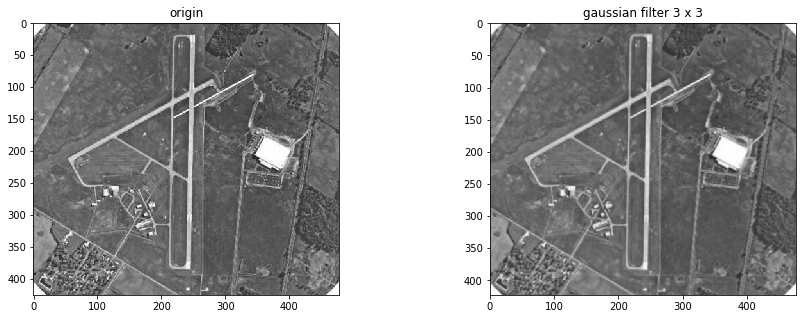

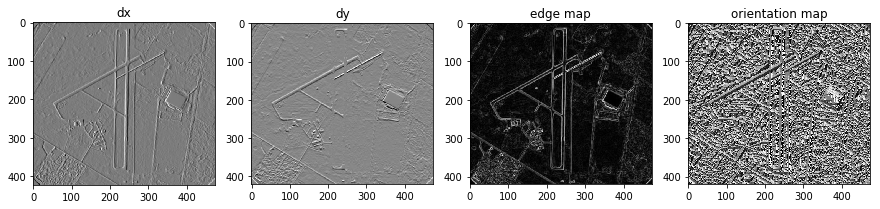

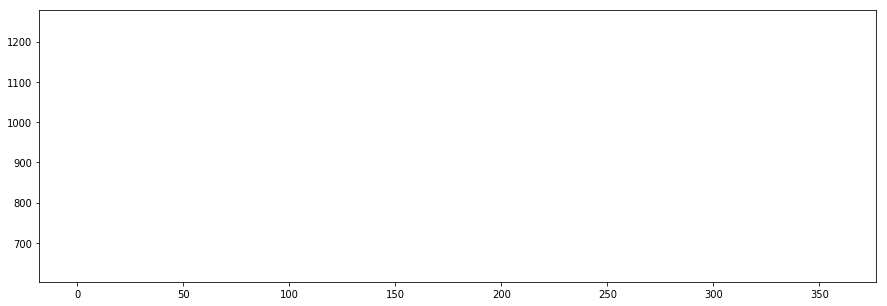

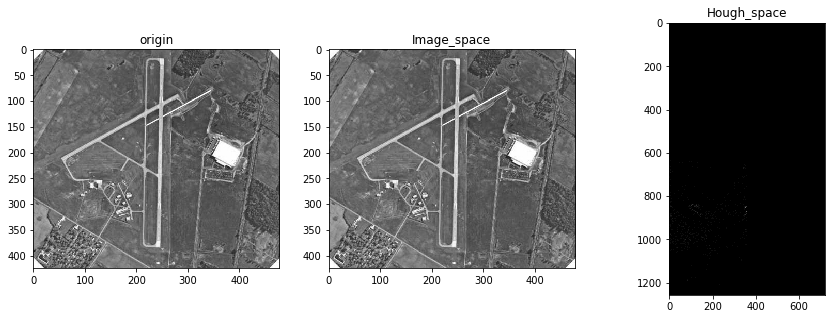

In [66]:
#---------------------------performing the Hough transformation
threthod=75
cell_size=1                        #set the cell size
                                    #stretch the theta axis to make a continus curve
x_sample_scale=2             #stretch the theta axis to make a good figure display
y_compress_scale=1

theta_resolution=720
#x_general_scale=theta_resolution/cell_size=360/2=180
#y_general_scale=max/y_compress_scale/cell_size=1200/6=200

squ1=squ_image(imageMatrix3,img3h,img3w)
edgeXY1,angleXY1=edge_laplacian(squ1)
Vote_img_ap=Img2Hough(edgeXY1,angleXY1,threthod,theta_resolution,y_compress_scale,cell_size,poll_mode="non_weighted",speed_up="yes")
Vote_img1=calibration(Vote_img_ap)
Vote_img1=rgb_kernel(Vote_img1)

showpic(rgb_kernel(squ1),rgb_kernel(squ1),Vote_img1,name1="Image_space",name2="Hough_space")



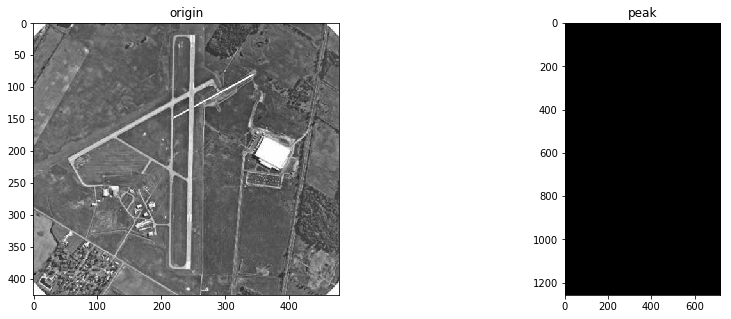

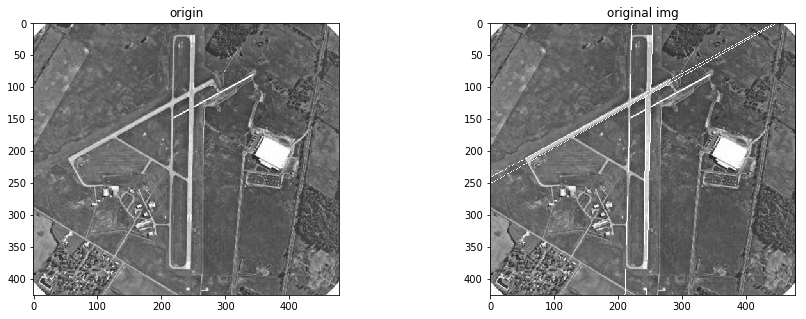

In [68]:
threthod=0.3
resolution=11
resolution=int(resolution/2)*2+1   #make the resolution an odd number

Vote_img2=calibration(Vote_img_ap)   #after image display,we need to calibration to return to normal

Vote_smooth=np.zeros(Vote_img2.shape)
Vote_smooth=conv_2d(gaussian_filter(resolution),Vote_img2,padding="reflect")

peak=peak_detection(Vote_smooth,resolution)   #use non-linear peak detection
newPK=np.zeros(peak.shape)#np.zeros(peak.shape)
newPK[peak>(threthod*peak.max())]=255


rgb_lvl=rgb_kernel(newPK)
showpic_g(rgb_kernel(squ1),rgb_lvl,name="peak")

temp_key=np.array(np.where(newPK==255),dtype=np.float)

final_key=Axis_shift_2D(temp_key[0],temp_key[1],newPK,mode=2)   
final_key=np.array(final_key)

final_key[0]=(final_key[0]*cell_size+int(cell_size/2))*y_compress_scale          #rou / x in matrix
final_key[1]=(final_key[1]*cell_size+int(cell_size/2))/theta_resolution*180      #theta /y in matrix
draw_lines(final_key[1],final_key[0],squ1)
